In [60]:
%load_ext autoreload
%autoreload 2

import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC
from numpyro.infer.util import initialize_model
from numpyro import handlers

# jax.config.update("jax_enable_x64", True)
# print(jax.devices())

sys.path.append('../')

from cofilin.forward_model.config import Constants, FMConfig
from cofilin.forward_model.fmodel import FModel
from cofilin.forward_model.fourier import my_ifft
from cofilin.forward_model.bias import manage_params
from cofilin.forward_model.plot_utils import plot_cubes, compare_pow_spec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
N, Z_I, Z_F = 64, 99, 0
R = 3.4*4
L = R*N

cte = Constants(N, L, Z_I, Z_F)

lpt_method = "2LPT"
MND = 1e-2
N_TR = L**3 * MND

det_bias_model = "LinearPowerLaw"
stoch_bias_model = "Poisson"

cweb = 'PhiWeb'
soft_cweb = True
cweb_sharpness = 10

fm_cfg = FMConfig(
    N,
    L,
    Z_I,
    Z_F,
    N_TR=N_TR,
    det_bias_model=det_bias_model,
    stoch_bias_model=stoch_bias_model,
    cweb=cweb,
    soft_cweb=soft_cweb,
    cweb_sharpness=cweb_sharpness
)
fmodel = FModel(fm_cfg)

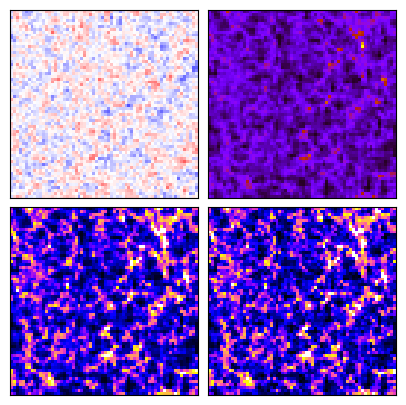

In [39]:
q_data = fmodel.input_arr(jax.random.PRNGKey(1))
delta_in_hat = fmodel.delta_in(q_data)
delta_in = my_ifft(delta_in_hat, cte.INV_L3)
delta_lpt = fmodel.delta_lpt(q_data)
cweb_arr = fmodel.cweb(delta_lpt)

get_n_tr_mean = fmodel.n_tr_mean()

key_params = jax.random.PRNGKey(0)
sks = jax.random.split(key_params, 3)

alpha = jax.random.normal(sks[0], (fm_cfg.n_regions,))*0.2 + 1
b = jax.random.normal(sks[1], (fm_cfg.n_regions,))*0.2 + 1
#beta = jax.random.normal(sks[2], (fm_cfg.n_regions,))*5 + 15

params = {"alpha": alpha, "b": b}
params = manage_params(params)
n_tr_mean = get_n_tr_mean(delta_lpt, params, cweb_arr)

key_sample = jax.random.PRNGKey(1)
n_tr_data = fmodel.sample_n_tr(n_tr_mean, key_sample, params=params, cweb=cweb_arr)

lim_dev = 10 * jnp.std(delta_lpt)
vlim_dev = (-1, lim_dev)

lim_n_tr = jnp.mean(n_tr_data) + 3 * jnp.std(n_tr_data)
vlim_n_tr = (0, lim_n_tr)

fig, ax = plot_cubes(
    [delta_in, delta_lpt, n_tr_mean, n_tr_data],
    cmap=["seismic_r", "gnuplot"]+["gnuplot2"]*2,
    vlim=[0.1, vlim_dev]+[vlim_n_tr]*2,
    width=1, axis=2, idx=N//2
)

In [41]:
model = fmodel.build_model() 

alpha_fixed = jnp.array([1.]*4) 
b_fixed = jnp.array([1.]*4) 

conditioned_model = handlers.condition(
    model,  # the model that still has sample("alpha", …)
    data={"alpha": alpha_fixed, 
          "b": b_fixed},
)
# def tempered_conditioned_model(data, T=1):
#     """Posterior ∝  [prior * likelihood]^(1/T)"""
#     with handlers.scale(scale=1.0 / T):
#         conditioned_model(data)

# def tempered_model(data, T=1):
#     """Posterior ∝  [prior * likelihood]^(1/T)"""
#     with handlers.scale(scale=1.0 / T):
#         model(data)

### NUTS Unconditioned

In [42]:
from numpyro.infer import init_to_value

key_q_init = jax.random.PRNGKey(11)
q_init = fmodel.input_arr(key_q_init) * 0.01
init_params = {"q": q_init}
init_strategy = init_to_value(values=init_params)

max_tree_depth = 8
adapt_mass_matrix = True
dense_mass = False

key = jax.random.PRNGKey(0)
kernel = NUTS(
    conditioned_model,
    dense_mass=dense_mass,
    adapt_mass_matrix=adapt_mass_matrix,
    max_tree_depth=max_tree_depth,
    adapt_step_size=True,
    init_strategy=init_to_value(values=init_params),
)
mcmc = MCMC(kernel, num_warmup=200, num_samples=100, thinning=5, progress_bar=True)
mcmc.run(key, data=n_tr_data)
posterior = mcmc.get_samples()

sample: 100%|██████████| 300/300 [01:13<00:00,  4.09it/s, 181 steps of size 5.44e-03. acc. prob=0.84]


In [47]:
prev_state = mcmc.last_state
# Unconstrained latent values
z0 = prev_state.z
# Tuned HMC hyper-parameters
eps0  = prev_state.adapt_state.step_size
invM0 = prev_state.adapt_state.inverse_mass_matrix
# --- 2. Build a new fixed-kernel that reuses them --------------------------
kernel2 = NUTS(
    conditioned_model,
    step_size=eps0,
    inverse_mass_matrix=invM0,
    dense_mass=False,
    adapt_step_size=False,     # no further step-size adaptation
    adapt_mass_matrix=False,   # keep the previous mass matrix
    max_tree_depth=8,
)
mcmc2 = MCMC(kernel2, num_warmup=100, num_samples=100, thinning=2, progress_bar=True)
# --- 3. Run from the last position z0 ------------------------------------
rng2 = jax.random.PRNGKey(1)
mcmc2.run(rng2, init_params=z0, data=n_tr_data)
posterior2 = mcmc2.get_samples()

warmup:  10%|█         | 20/200 [00:13<00:50,  3.56it/s, 161 steps of size 5.44e-03. acc. prob=0.82]

sample: 100%|██████████| 200/200 [00:54<00:00,  3.69it/s, 255 steps of size 5.44e-03. acc. prob=0.86]


(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: xlabel='$k$ [$h$/Mpc]'>, <Axes: xlabel='$k$ [$h$/Mpc]'>,
        <Axes: xlabel='$k$ [$h$/Mpc]'>], dtype=object))

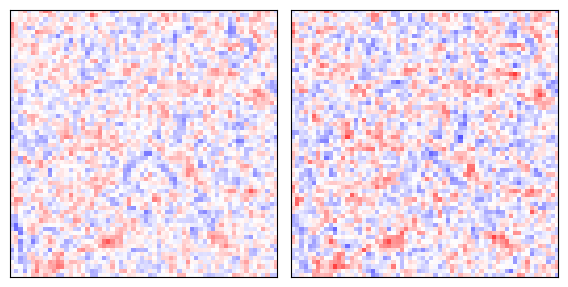

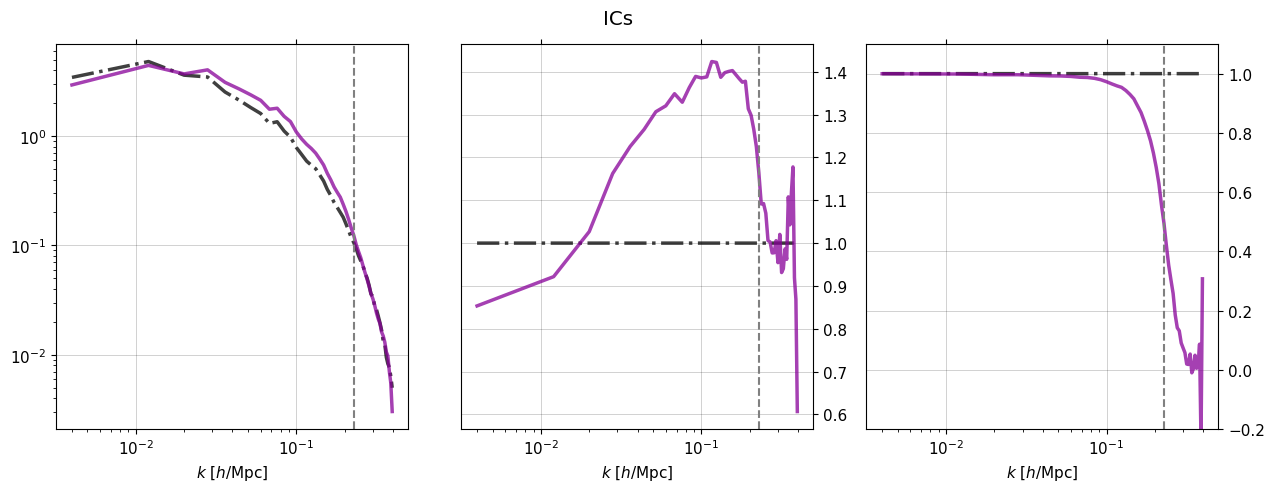

In [48]:
delta_in_fit_hat = fmodel.delta_in(posterior2['q'][-1])
delta_in_fit = my_ifft(delta_in_fit_hat, cte.INV_L3)

plot_cubes([delta_in, delta_in_fit], cmap='seismic_r', vlim=1e-1)
compare_pow_spec([delta_in, delta_in_fit], L=L, xlog=True, no_labels=['Reference', 'Fit'], title='ICs')

In [49]:
q_init = mcmc2.get_samples()["q"][0]
init_vals = {"q": q_init, "alpha": alpha_fixed, "b": b_fixed}
from numpyro.infer import init_to_value
init_strat = init_to_value(values=init_vals)

kernel2 = NUTS(
    model,
    dense_mass=False,
    adapt_mass_matrix=True,
    adapt_step_size=True,
    max_tree_depth=8,
    init_strategy=init_strat
)
mcmc2 = MCMC(kernel2, num_warmup=200, num_samples=200, thinning=50)
mcmc2.run(jax.random.PRNGKey(2), data=n_tr_data)
posterior = mcmc2.get_samples()

sample: 100%|██████████| 400/400 [01:47<00:00,  3.73it/s, 121 steps of size 5.13e-03. acc. prob=0.86]


(<Figure size 1500x500 with 3 Axes>,
 array([<Axes: xlabel='$k$ [$h$/Mpc]'>, <Axes: xlabel='$k$ [$h$/Mpc]'>,
        <Axes: xlabel='$k$ [$h$/Mpc]'>], dtype=object))

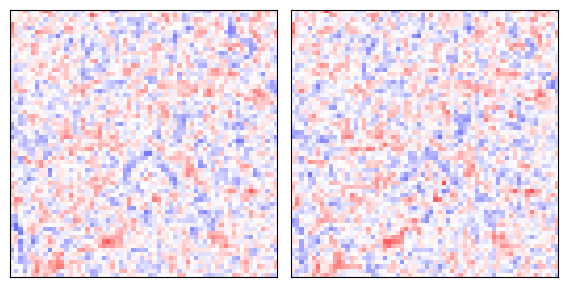

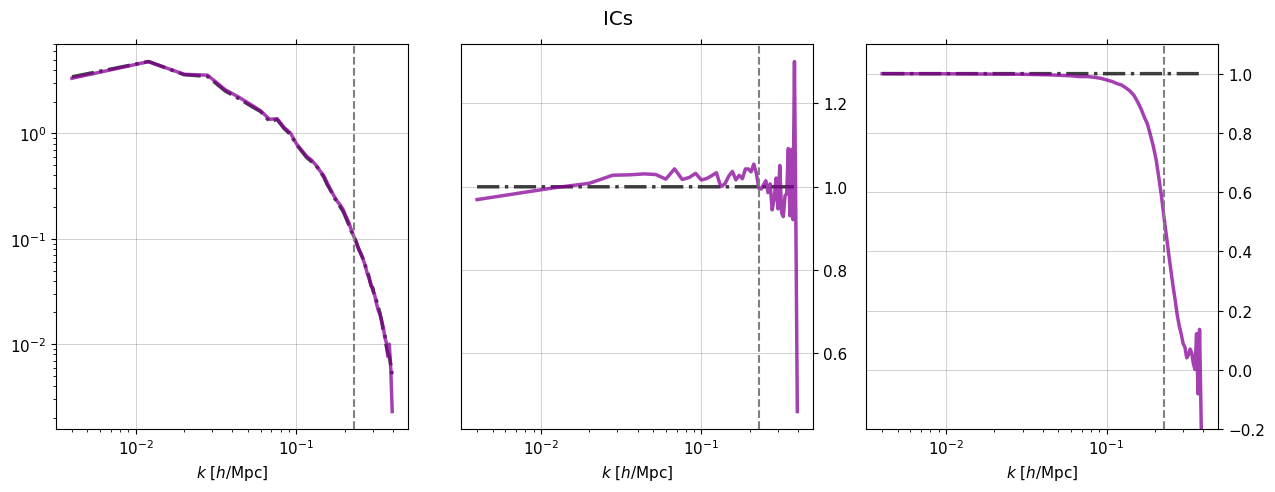

In [55]:
delta_in_fit_hat = fmodel.delta_in(posterior['q'][-2])
delta_in_fit = my_ifft(delta_in_fit_hat, cte.INV_L3)

plot_cubes([delta_in, delta_in_fit], cmap='seismic_r', vlim=1e-1)
compare_pow_spec([delta_in, delta_in_fit], L=L, xlog=True, no_labels=['Reference', 'Fit'], title='ICs')

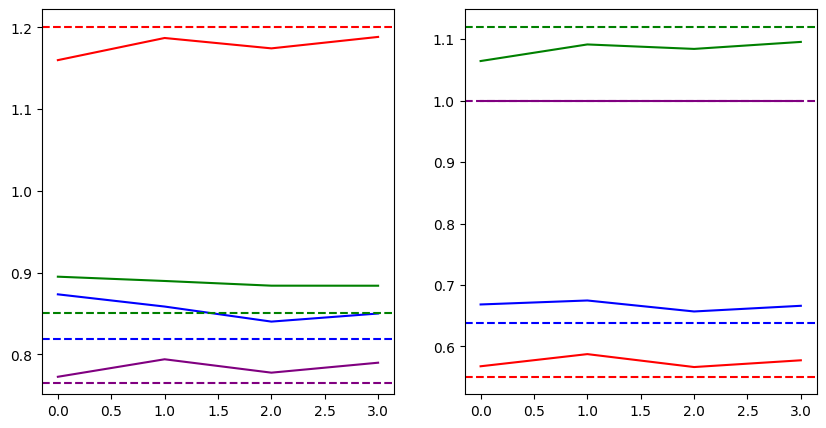

In [59]:
fs, rat = 5, 2
fig, axs = plt.subplots(1, 2, figsize=(fs*rat, fs))

cs = ['r', 'b', 'g', 'purple']
for i in range(4):
    axs[0].plot(posterior['alpha'][:,i], c=cs[i])
    axs[0].axhline(params['alpha'][i], c=cs[i], ls='--')

    axs[1].plot(posterior['b'][:,i]/posterior['b'][:,3], c=cs[i])
    axs[1].axhline(params['b'][i]/params['b'][3], c=cs[i], ls='--')